# MLP on the CIFAR-10 Dataset

Trains three simple NNs with 3 hidden layers on the CIFAR-10 dataset.

Gets to ~46% validation accuracy after 100 epochs (mean squared loss) (Residual Connection)

Gets to ~47% validation accuracy after 100 epochs (mean squared loss) (MLP)

Gets to ~52% validation accuracy after 100 epochs (cross-entropy loss) (MLP)

(there is *a lot* of margin for parameter tuning).

~ 6 seconds per epoch on a GTX1070 GPU.


## Import the Tensorflow package (for Keras) and Reproducility

In [1]:
import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

seed = 20

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(seed)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

## Import the CIFAR-10 dataset

In [2]:
from __future__ import print_function

# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import RMSprop
# from keras import regularizers
# import tensorflow as tf

batch_size = 512
num_classes = 10
epochs = 100

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#print(x_train[0,0:10,0,0])

50000 train samples
10000 test samples


## Visualize Some Training Samples

The first 5 images, followed by 25 random images:


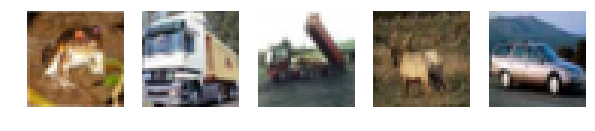

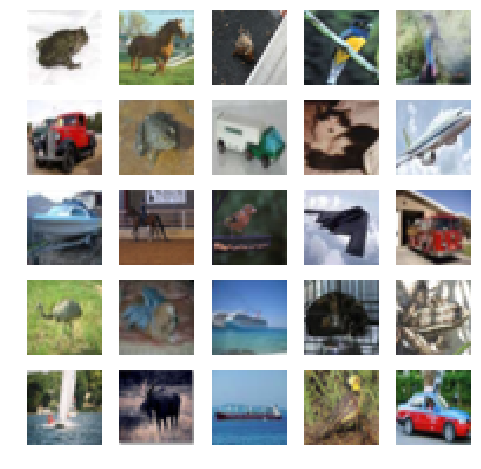

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


fig, axes = plt.subplots(1,5,figsize=(10,10))
print('The first 5 images, followed by 25 random images:')
for i in range(5):
    axes[i].set_axis_off()
    axes[i].imshow(x_train[i], interpolation='nearest')

fig1, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x_train[i:i+1][0], interpolation='nearest')

## Data Transformation

In [4]:
x_train = x_train.reshape((50000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
x_test = x_test.reshape((10000, 3*32*32), order='F') # reshaping order fixed to the same as BCD
#print(x_train[0,0:10])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# The First Model (Residual Connection)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> Add Input -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [ ]:
# model
x1 = tf.keras.layers.Input(shape=(3072,))
a1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x1)
a2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a1)
a2 = tf.keras.layers.Add()([a2, x1])
a3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a2)
y_mlp = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(a3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model = tf.keras.models.Model(inputs=x1, outputs=y_mlp)

model.summary()

sgd1 = tf.keras.optimizers.SGD(lr=0.01, decay=0, momentum=0.95, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd1, metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3072)         9440256     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3072)         9440256     dense_1[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 3072)         0           dense_2[0][0]                    
                                                                 input_1[0][0]                    
__________

## Fit the Model using Back Propagation (Vanilla SGD; lr = 0.01)

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# print('Test error:', 1-score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.0893 - acc: 0.2877 - val_loss: 0.0792 - val_acc: 0.3915
Epoch 2/100
 - 5s - loss: 0.0779 - acc: 0.3951 - val_loss: 0.0766 - val_acc: 0.4170
Epoch 3/100
 - 5s - loss: 0.0760 - acc: 0.4193 - val_loss: 0.0752 - val_acc: 0.4302
Epoch 4/100
 - 5s - loss: 0.0747 - acc: 0.4359 - val_loss: 0.0742 - val_acc: 0.4385
Epoch 5/100
 - 5s - loss: 0.0737 - acc: 0.4470 - val_loss: 0.0735 - val_acc: 0.4446
Epoch 6/100
 - 5s - loss: 0.0728 - acc: 0.4574 - val_loss: 0.0729 - val_acc: 0.4493
Epoch 7/100
 - 5s - loss: 0.0721 - acc: 0.4652 - val_loss: 0.0724 - val_acc: 0.4540
Epoch 8/100
 - 5s - loss: 0.0715 - acc: 0.4712 - val_loss: 0.0719 - val_acc: 0.4591
Epoch 9/100
 - 5s - loss: 0.0709 - acc: 0.4786 - val_loss: 0.0715 - val_acc: 0.4637
Epoch 10/100
 - 5s - loss: 0.0704 - acc: 0.4834 - val_loss: 0.0711 - val_acc: 0.4676
Epoch 11/100
 - 5s - loss: 0.0699 - acc: 0.4885 - val_loss: 0.0707 - val_acc: 0.4702
Epoch 12/100
 - 5s - los

## Loss and Accuracy Plots

In [ ]:
# Plot of Losses
history_dict = history.history
# history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs_index = range(1,len(loss_values)+1)

fig_loss = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values, 'b', c='orange', label='Validation loss')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer Fully-connected Network (2nd ResNet Hidden Layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
fig_accuracy.savefig('fig_accuracy_cifar.eps', format='eps', dpi=2000)

# The Second Model (MLP)

## Model Setup

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Mean squared loss

In [ ]:
# model
x0 = tf.keras.layers.Input(shape=(3072,))
u1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(x0)
u2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u1)
u3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u2)
y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(u3)
#y_mlp = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(a3)

model_2 = tf.keras.models.Model(inputs=x0, outputs=y_mlp_2)

model_2.summary()

sgd2 = tf.keras.optimizers.SGD(lr=0.05, decay=0, momentum=0.95, nesterov=False)
model_2.compile(loss='mean_squared_error', optimizer=sgd2, metrics=['accuracy'])

## Fit the Model using Back Propagation (Vanilla SGD; lr = 0.05)

In [ ]:
history_2 = model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_2 = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])
#print('Test error:', 1-score[1])

## Loss and Accuracy Plots

In [ ]:
# Plot of Losses
history_dict_2 = history_2.history
# history_dict.keys()
loss_values_2 = history_dict_2['loss']
val_loss_values_2 = history_dict_2['val_loss']
acc_values_2 = history_dict_2['acc']
val_acc_values_2 = history_dict_2['val_acc']

epochs_index = range(1,len(loss_values_2)+1)
fig_loss_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_2, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_2, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_2 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_2,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_2,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [ ]:
fig_accuracy_2.savefig('fig_accuracy_cifar_2.eps', format='eps', dpi=2000)

# The Third Model (MLP) (Cross-entropy Loss)

Input -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (3072) -> ReLU -> Fully Connected (10) -> Softmax -> Cross-entropy loss

In [ ]:
# model
z0 = tf.keras.layers.Input(shape=(3072,))
z1 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z0)
z2 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z1)
z3 = tf.keras.layers.Dense(3072, activation='relu', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z2)
#y_mlp_2 = tf.keras.layers.Dense(num_classes, activation=None, use_bias=True)(z3)
y_mlp_3 = tf.keras.layers.Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seed), bias_initializer=tf.keras.initializers.Constant(value=0.1))(z3)

model_3 = tf.keras.models.Model(inputs=z0, outputs=y_mlp_3)

model_3.summary()

sgd3 = tf.keras.optimizers.SGD(lr=0.01, decay=0, momentum=0.95, nesterov=False)
model_3.compile(loss='categorical_crossentropy', optimizer=sgd3, metrics=['accuracy'])

## Fit the Model using Back Propagation (Vanilla SGD)

In [ ]:
history_3 = model_3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    shuffle=False)
score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])
#print('Test error:', 1-score[1])

## Loss and Accuracy Plots

In [ ]:
# Plot of Losses
history_dict_3 = history_3.history
# history_dict.keys()
loss_values_3 = history_dict_3['loss']
val_loss_values_3 = history_dict_3['val_loss']
acc_values_3 = history_dict_3['acc']
val_acc_values_3 = history_dict_3['val_acc']

epochs_index = range(1,len(loss_values_3)+1)
fig_loss_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index, loss_values_3, 'b', label='Training loss')
plt.plot(epochs_index, val_loss_values_3, 'b', c='orange', label='Validation loss')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



#%%
# Plot of Accuracies
plt.clf()
fig_accuracy_3 = plt.figure(figsize=(6, 6))
plt.plot(epochs_index,acc_values_3,'b', label='Training accuracy')
plt.plot(epochs_index,val_acc_values_3,'b', c='orange', label='Validation accuracy')
plt.title('Three-layer MLP')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the Plots

In [ ]:
fig_accuracy_3.savefig('fig_accuracy_cifar_3.eps', format='eps', dpi=2000)